In [1]:
%matplotlib notebook

import numpy as np

# Synthetic Data (4 Layers, 10 Time Steps)

In [2]:
from multidynet.datasets import simple_dynamic_multilayer_network
from multidynet.plots import plot_network

lmbda = np.array([[1., 1.],
                  [0.5, -0.5],
                  [-2.0, 2.0],
                  [-1., -1.]])

Y, X, lmbda, delta = simple_dynamic_multilayer_network(
    n_nodes=100, n_time_steps=10,
    tau_sq=4.0, sigma_sq=0.1,
    lmbda=lmbda, 
    assortative_reference=False,
    random_state=423)

## Layer 1

<IPython.core.display.Javascript object>


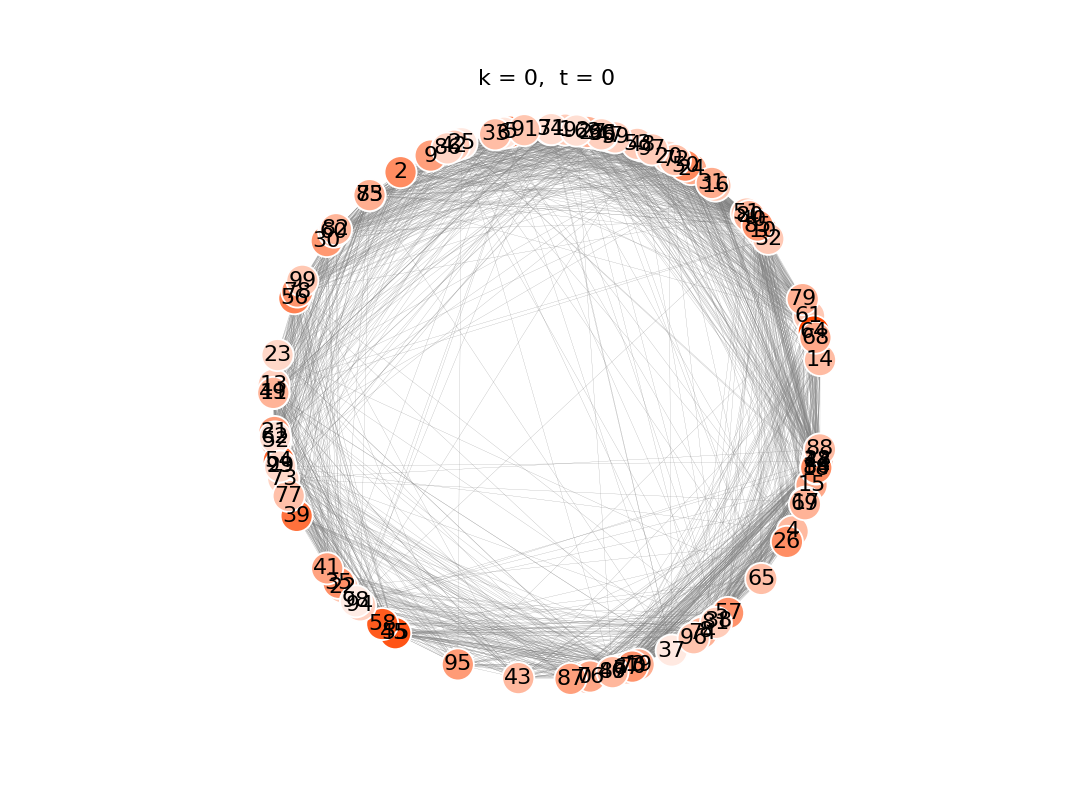

Text(0.5, 1.0, 'k = 0,  t = 0')

In [75]:
t = 0
k = 0

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 2

<IPython.core.display.Javascript object>


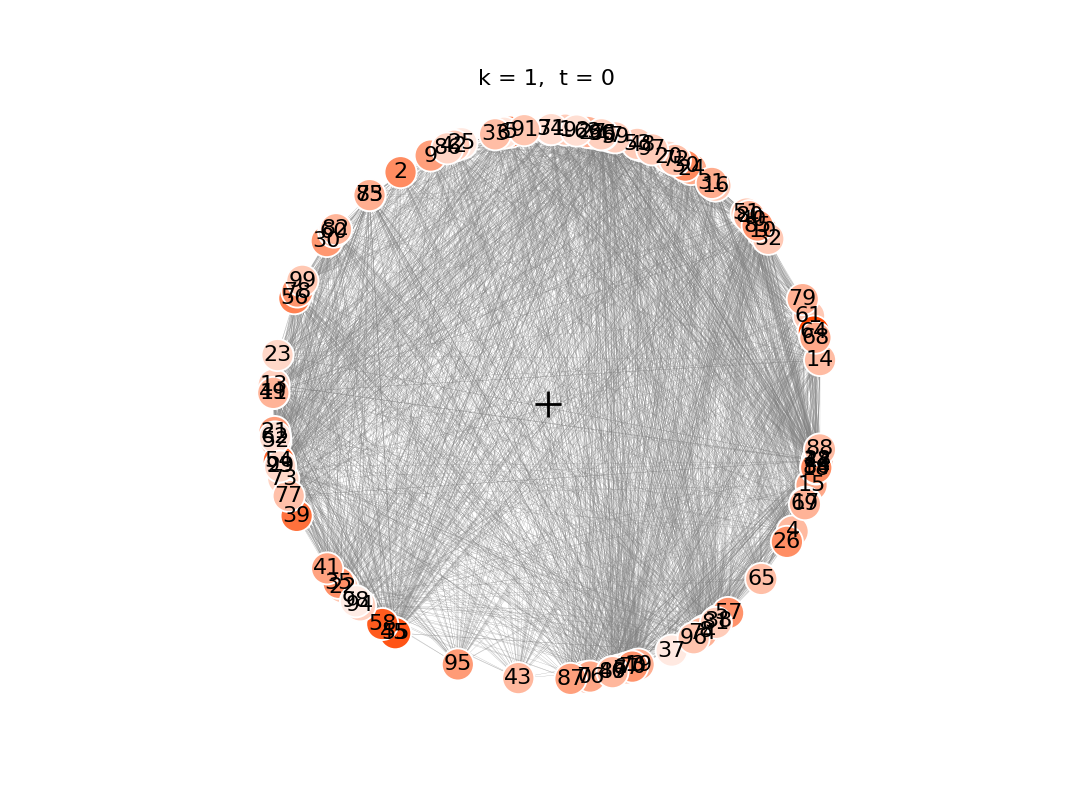

Text(0.5, 1.0, 'k = 1,  t = 0')

In [4]:
t = 0
k = 1

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 3

<IPython.core.display.Javascript object>


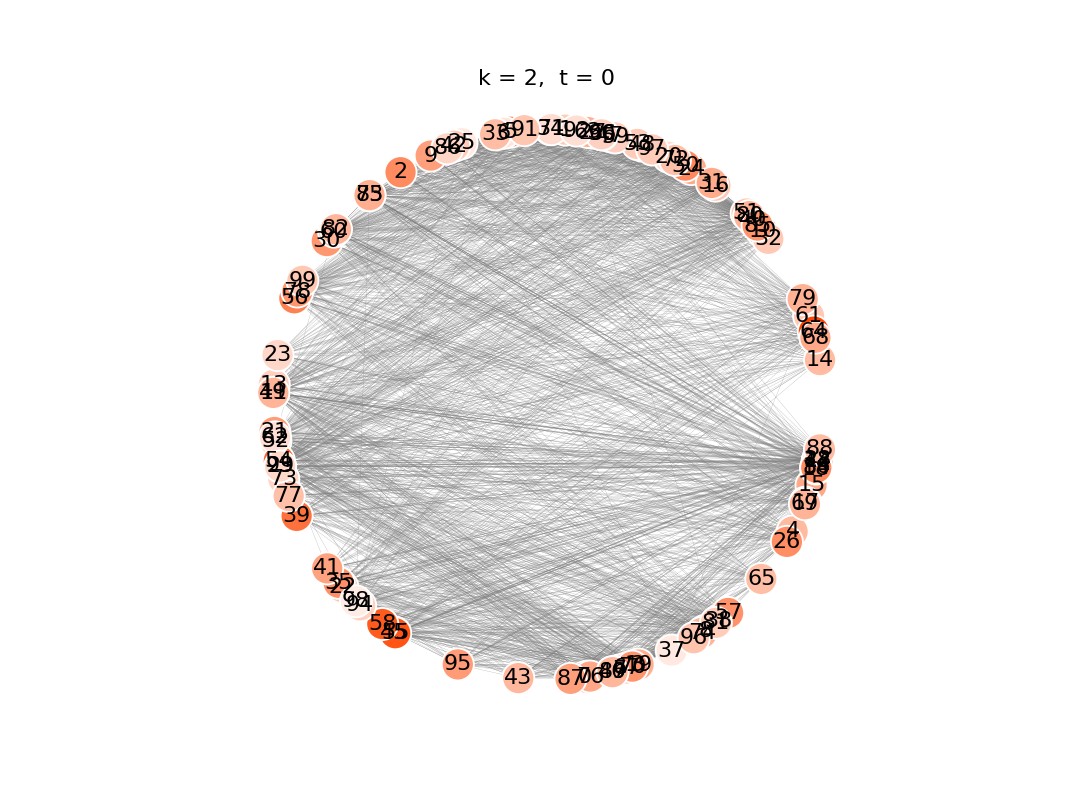

Text(0.5, 1.0, 'k = 2,  t = 0')

In [77]:
t = 0
k = 2

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 4

<IPython.core.display.Javascript object>


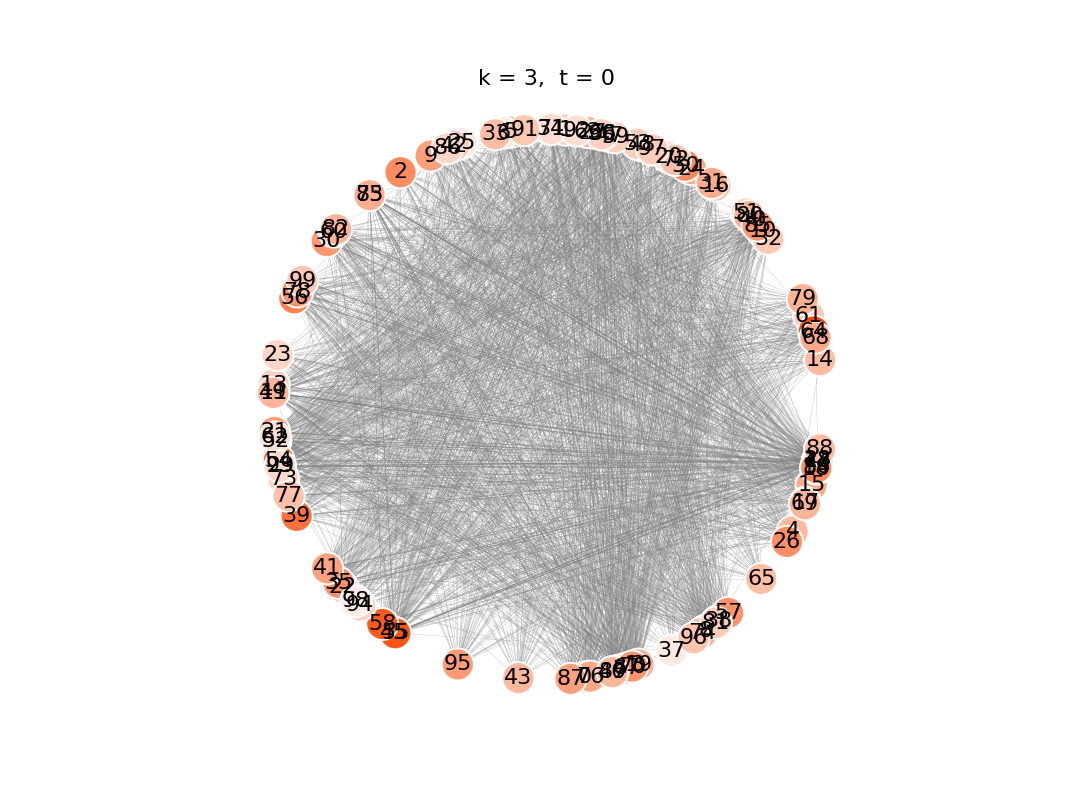

Text(0.5, 1.0, 'k = 3,  t = 0')

In [78]:
t = 0
k = 3

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

# Model Estimation

In [ ]:
from multidynet import DynamicMultilayerNetworkLSM
from multidynet.model_selection import train_test_split

# Hold-out 10% of dyads for testing
Y_train, test_indices = train_test_split(Y, test_size=0.1)

model = DynamicMultilayerNetworkLSM(max_iter=500, 
                                    #a=4.0, b=20.0, c=10, d=0.1, 
                                    #lambda_var_prior=4., 
                                    #lambda_odds_prior=2,
                                    #tol=1e-2,
                                    n_jobs=-1,
                                    n_init=8,
                                    random_state=123)
model.fit(Y_train)

<IPython.core.display.Javascript object>


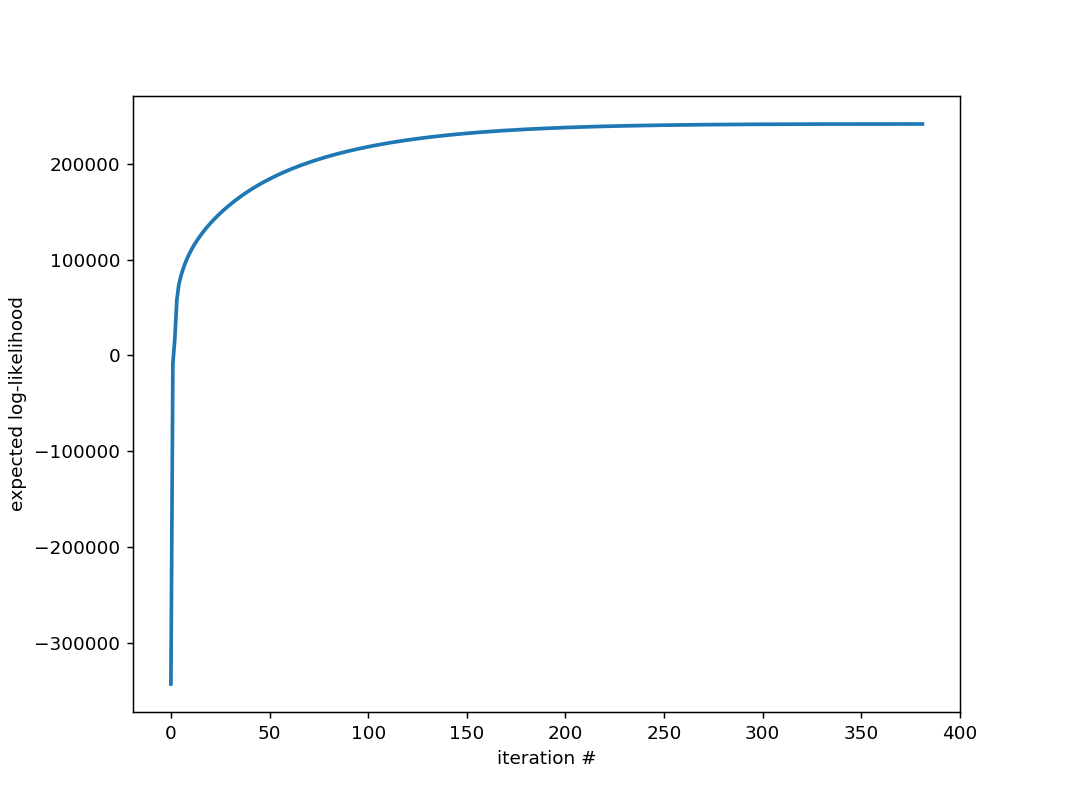

Text(0.5, 0, 'iteration #')

In [6]:
fig, ax= plt.subplots(figsize=(8, 6))
ax.plot(model.logp_, lw=2)
ax.set_ylabel('expected log-likelihood')
ax.set_xlabel('iteration #')

# Parameter Estimates

# $\Lambda_k$

In [7]:
model.lambda_

array([[ 1.        ,  1.        ],
       [-0.50178088,  0.51427263],
       [ 1.9099414 , -1.94143523],
       [-1.01360282, -1.03332459]])

# $\beta_k$

In [9]:
model.delta_[0]

array([ 0.26357459, -0.1368509 ,  0.49095581, -1.73712991, -0.81355116,
        1.4127273 ,  1.21981565, -0.59901636,  0.04027379, -0.78640828,
       -1.09660908,  0.28150385, -0.25008058,  0.17808282, -0.30346848,
        2.26790558,  1.49809402,  0.23080497,  0.87247892, -0.60595674,
        0.71916201,  1.14949736, -0.50595855,  0.77212132,  3.32507648,
        0.31966724, -0.09712127, -0.5423309 ,  0.16826335, -1.45519855,
       -0.0653085 , -0.23676628, -1.38715424, -1.68132066,  0.43122001,
       -0.63662034, -0.74026581, -0.60740576,  0.49338721, -0.98747288,
        1.06357989,  1.26266046, -0.17831812, -0.62992941,  1.20707806,
        0.18318963, -1.21332284, -1.31303971, -1.15596733, -0.21229033,
        0.58962549,  0.98595252,  0.11163954,  0.84298928,  1.041297  ,
       -0.19141776,  1.25962246, -0.591222  ,  0.45517766, -0.07366563,
       -0.10580773, -0.38932902, -1.2123767 ,  0.43686107,  1.82119216,
        0.83319492,  0.06328411,  2.20880129,  0.86227687, -0.86

# $\tau^2$

In [11]:
model.tau_sq_

4.556367167350513

# $\sigma^2$

In [12]:
model.sigma_sq_

0.06419282877084777

## Latent Space 

<IPython.core.display.Javascript object>


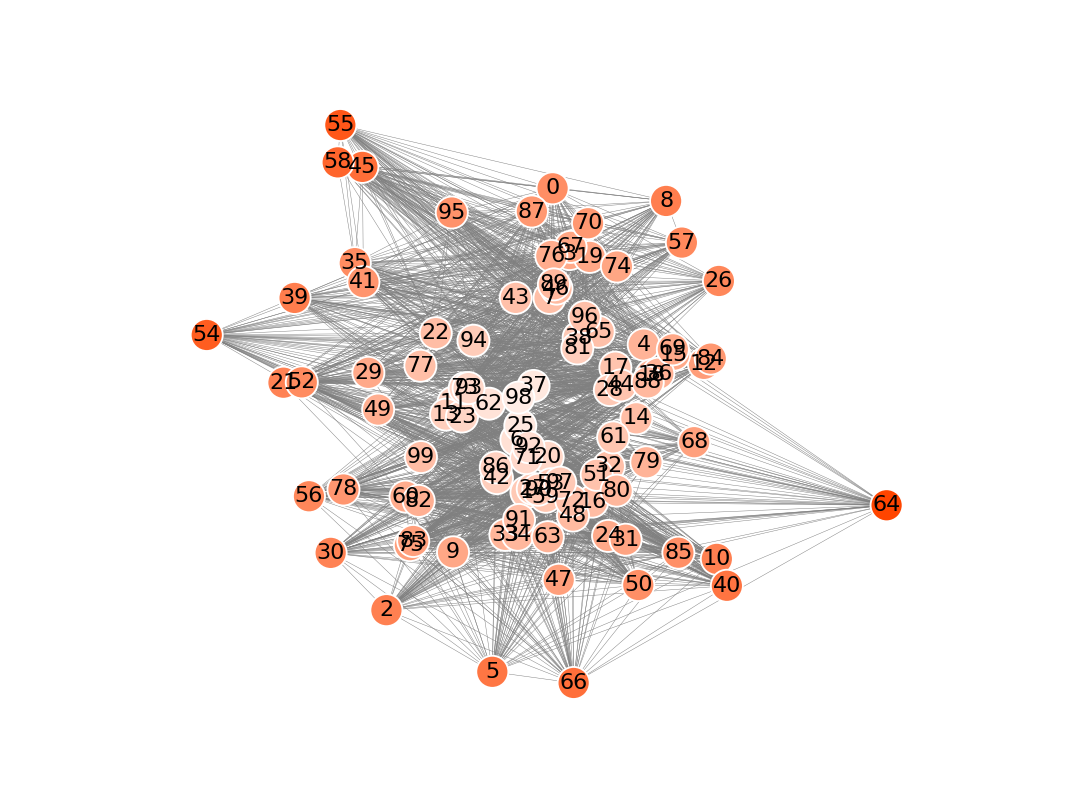

In [96]:
from multidynet.plots import plot_network

t = 0
k = 2
ax = plot_network(Y[k, t],model.X_[t], normalize=False, with_labels=True)

# Performance Diagnostics

## In-sample AUC

In [13]:
model.auc_

0.9672653997136405

## Held-out AUC

In [14]:
from multidynet.metrics import calculate_auc

calculate_auc(Y, model.probas_, test_indices)

0.9646571756601607

## Connection Probability Estimates

<IPython.core.display.Javascript object>


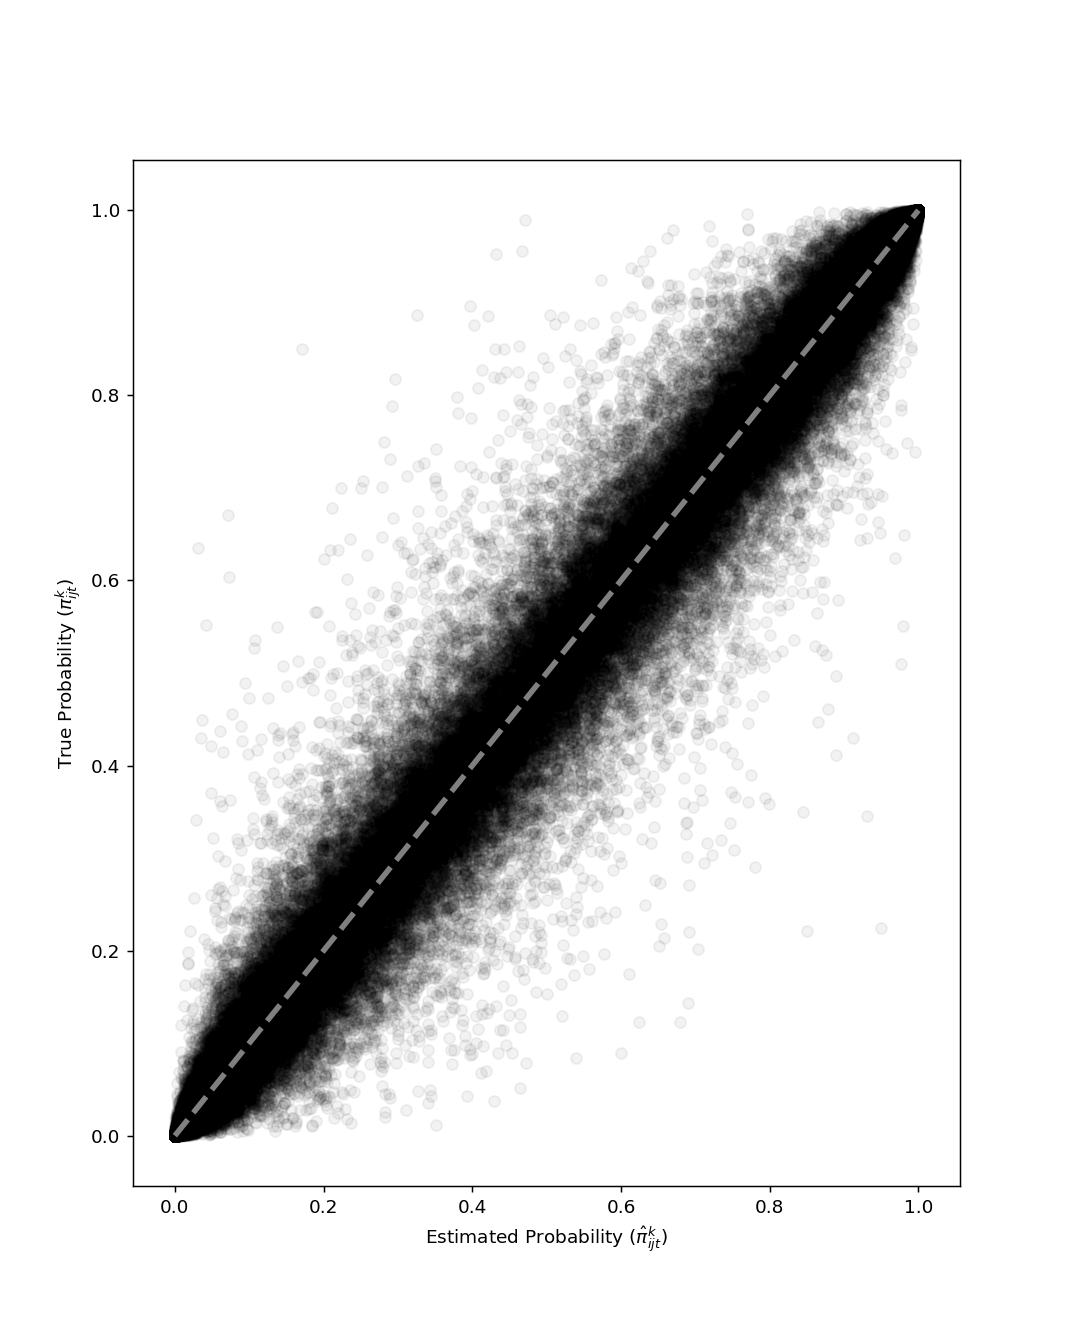

Text(0.5, 0, 'Estimated Probability ($\\hat{\\pi}_{ijt}^k$)')

In [17]:
import seaborn as sns
from scipy.special import expit

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))

p_true = np.zeros((n_layers, n_time_steps, n_dists))
p_est = np.zeros((n_layers, n_time_steps, n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        #d_est = expit(
        #    model.intercept_[k] + np.dot(model.X_[t] * model.lambda_[k], model.X_[t].T))
        d_est = model.probas_[k, t]
        
        deltak = delta[k].reshape(-1, 1)
        d_true = expit(np.add(deltak, deltak.T)+ np.dot(X[t] * lmbda[k], X[t].T))

        indices = np.tril_indices_from(d_est, k=-1)
        p_true[k, t] = d_true[indices]
        p_est[k, t] = d_est[indices]

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, '--', color='gray', lw=3)
ax.scatter(p_est.ravel(), p_true.ravel(), alpha=0.05, c='k')
ax.set_ylabel('True Probability ($\pi_{ijt}^k$)')
ax.set_xlabel('Estimated Probability ($\hat{\pi}_{ijt}^k$)')

In [72]:
import pickle

pickle.dump(model, open('model_types_n100_t10.pkl', 'wb'))